In [1]:
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def get_data_list(run_dump):
  if not os.path.exists(run_dump):
    raise IOError('File {0} not found'.format(run_dump))

  data=defaultdict(list)
  header=None
  data_header=None
  with open(run_dump,'r') as fp:
    for line in fp:
      line=line.strip()
      if line.startswith('#'):
        if line.startswith('# Version') or \
           line.startswith('# Column Count') or \
           line.startswith('# Bin Count') or \
           line.startswith('# Channel Count'):
          pass
        else:
          header=line.strip('# ').split(',')[0]
      else:
        if header is not None:
          if 'Lane' in line.split(','):
            data_header=line.split(',')
            continue
          if data_header is not None:
            data[header].append(dict(zip(data_header,line.split(','))))

  return data

In [3]:
%%bash
/home/vmuser/miniconda3/envs/pipeline-env/bin/interop_dumptext \
180918_K00345_0073_AH2HWLBBXY/ > 180918_K00345_0073_AH2HWLBBXY/dumptext.txt

In [4]:
data=get_data_list(run_dump='180918_K00345_0073_AH2HWLBBXY/dumptext.txt')

In [5]:
CorrectedInt=pd.DataFrame(data.get('CorrectedInt'))

## Flow cell chart

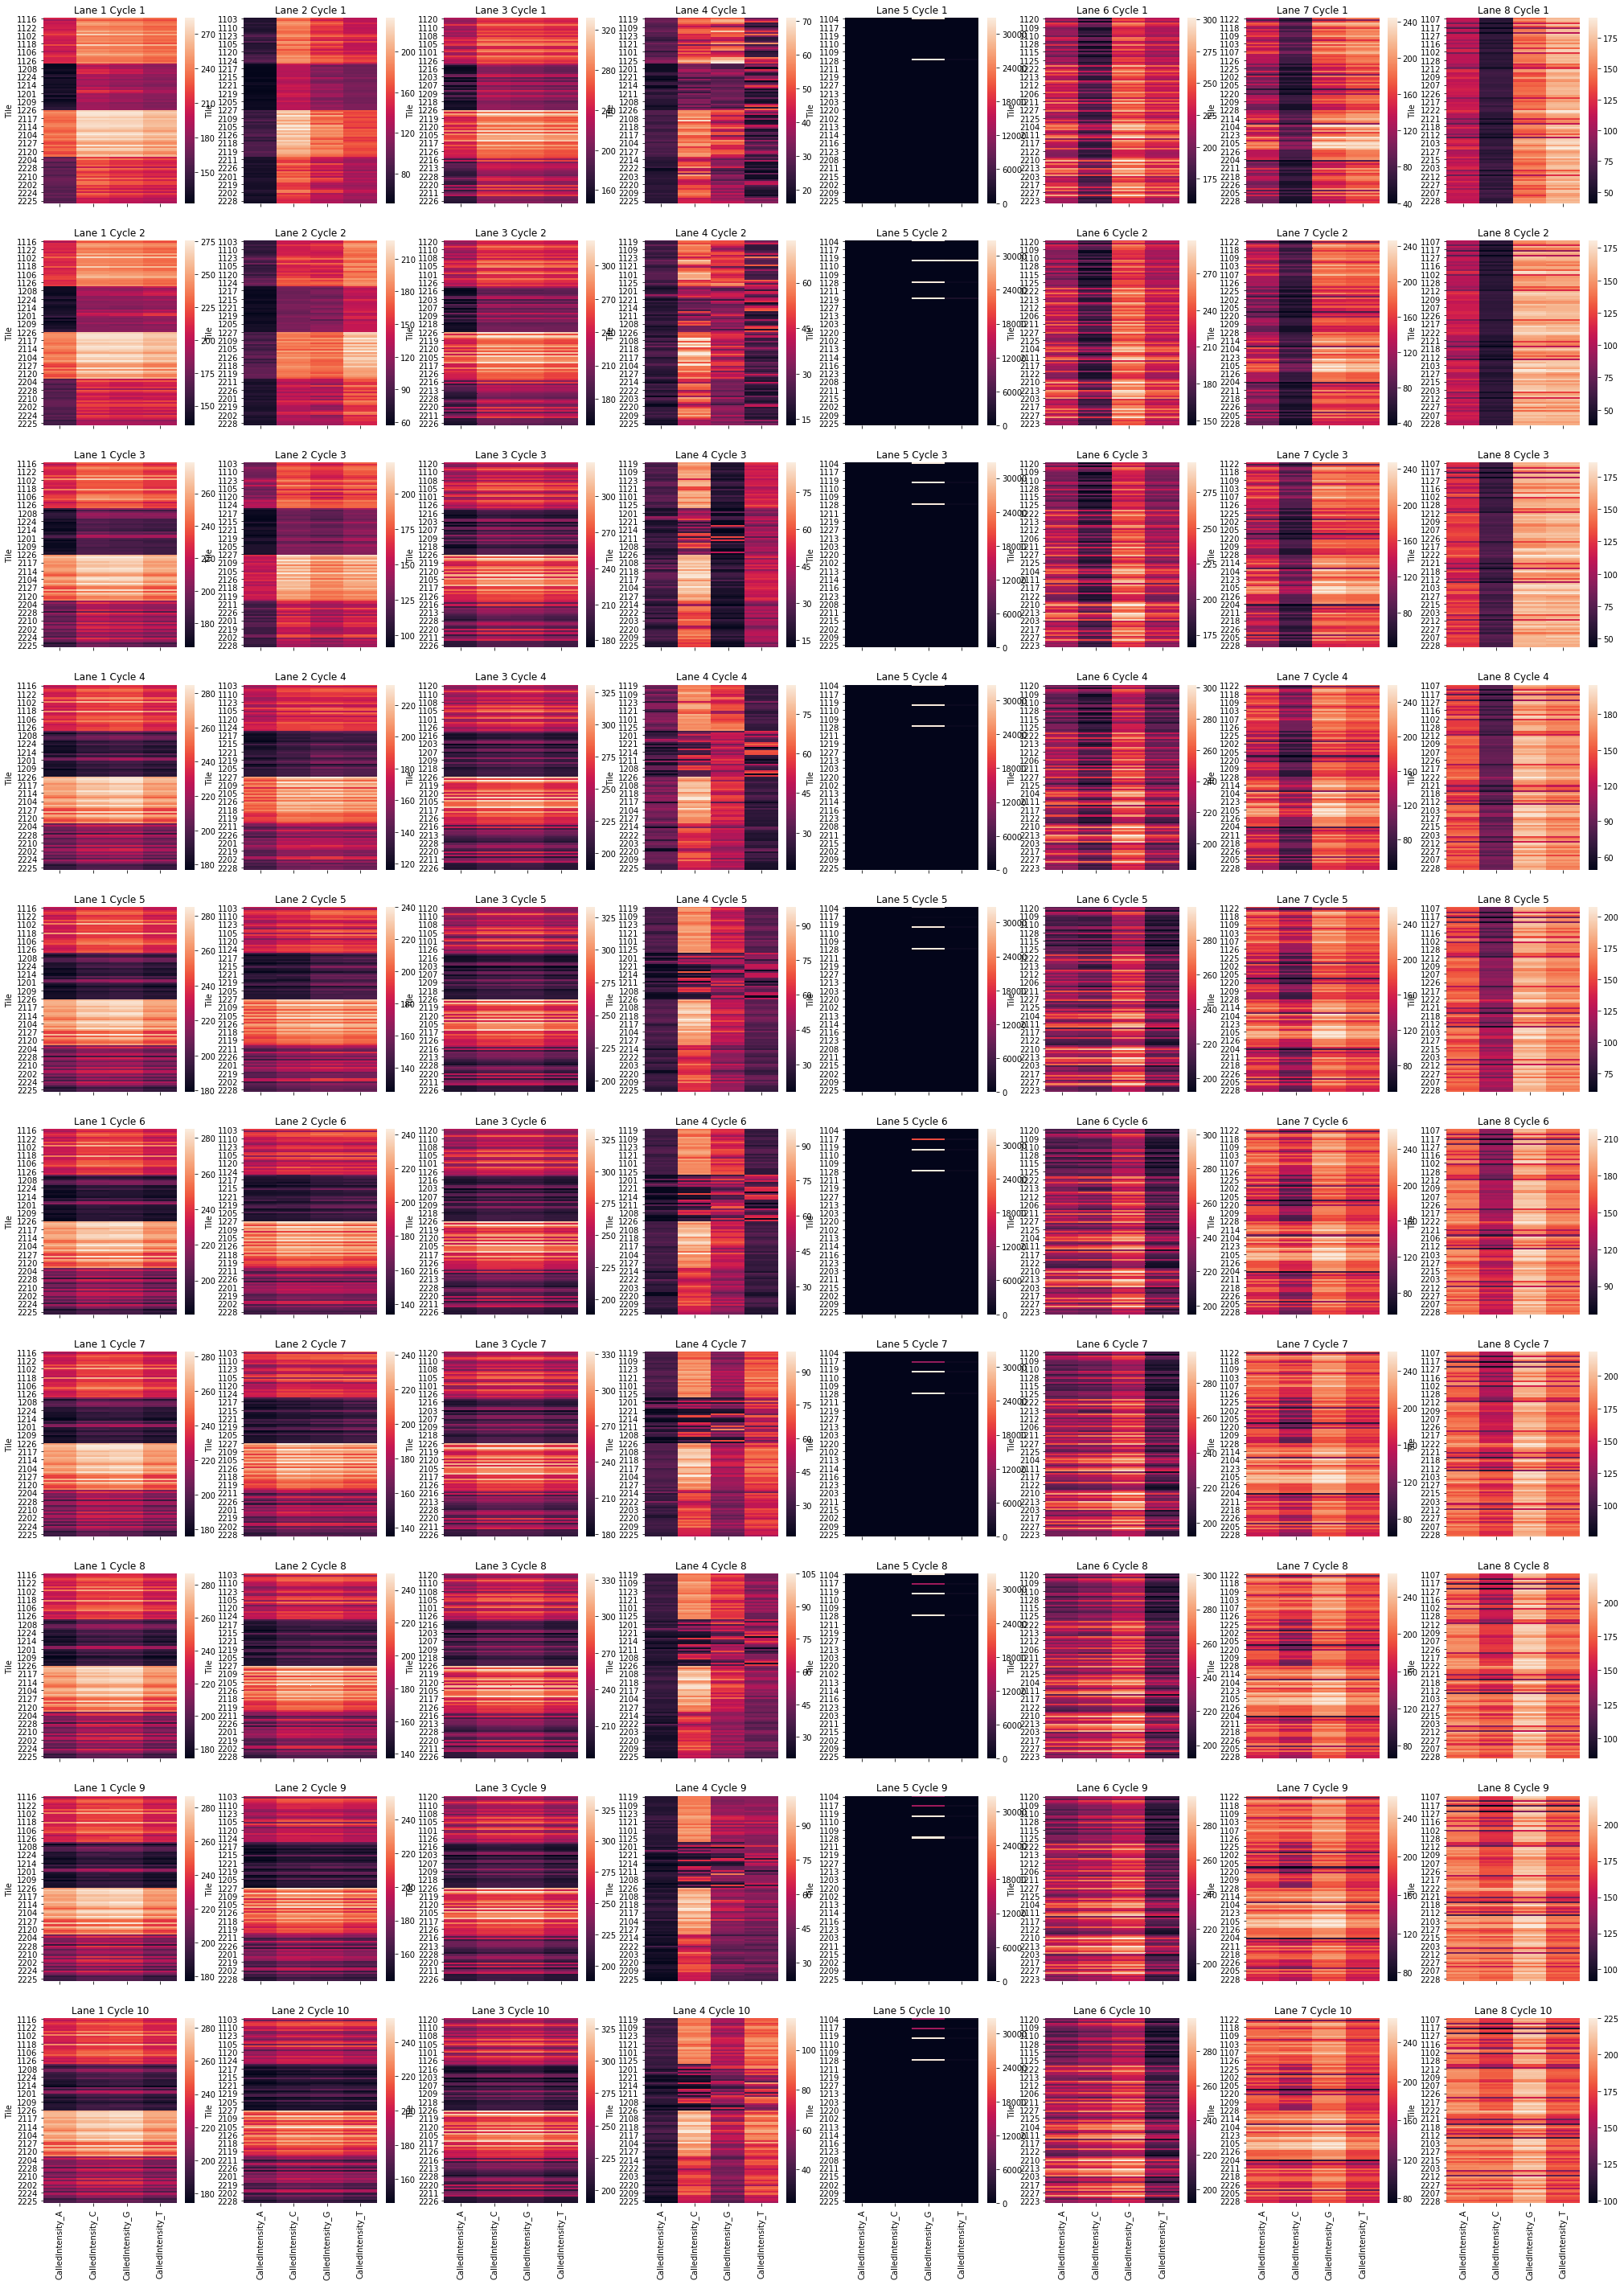

In [8]:
fig,ax=plt.subplots(10,8,figsize=(35,50),sharex=True)
for lane in range(1,9):
  for cycle in range(1,11):
    c_data=CorrectedInt.\
    groupby('Lane').\
    get_group(str(lane)).\
    groupby('Cycle').\
    get_group(str(cycle)).\
    set_index('Tile')\
           [['CalledIntensity_A',
             'CalledIntensity_C',
             'CalledIntensity_G',
             'CalledIntensity_T']].\
    applymap(lambda x: float(x))
    sns.heatmap(c_data,ax=ax[cycle-1,int(lane)-1])
    ax[cycle-1,int(lane)-1].set_title('Lane {0} Cycle {1}'.\
                                      format(lane,cycle));

## Data by cycle

In [19]:
t_data=list()
for lane in range(1,9): # CorrectedInt.groupby('Lane'):
  l_data=CorrectedInt.\
         groupby('Lane').\
         get_group(str(lane))
  for cycle,c_data in l_data.groupby('Cycle'):
    t_data.\
    append({'Lane':lane,
            'Cycle':cycle,
            'CalledIntensity_A':c_data['CalledIntensity_A'].median(),
            'CalledIntensity_C':c_data['CalledIntensity_C'].median(),
            'CalledIntensity_G':c_data['CalledIntensity_G'].median(),
            'CalledIntensity_T':c_data['CalledIntensity_T'].median()
          })
t_data=pd.DataFrame(t_data)
t_data['Cycle']=t_data['Cycle'].astype(int)
t_data['Lane']=t_data['Lane'].astype(int)

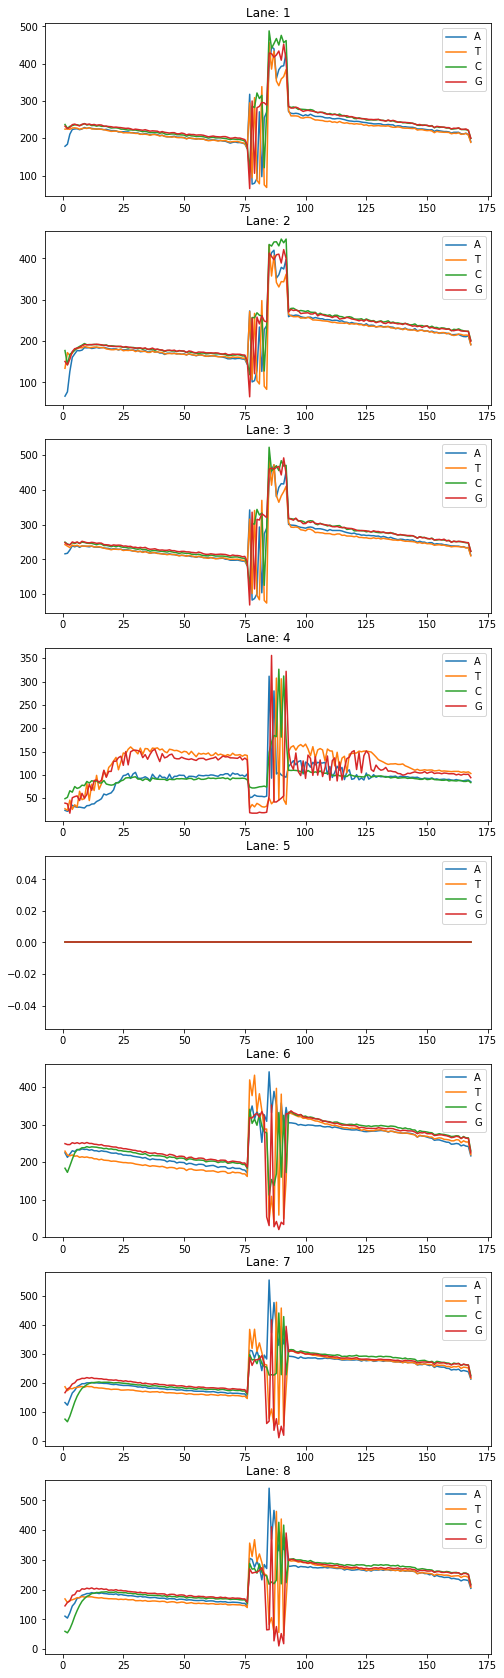

In [20]:
fig,ax=plt.subplots(8,1,figsize=(8,30))
for lane in range(1,9): # t_data.groupby('Lane'):

  c_data=t_data.\
         groupby('Lane').\
         get_group(lane).\
         sort_values('Cycle')
  ax[lane-1].plot(c_data['Cycle'],c_data['CalledIntensity_A'],label='A')
  ax[lane-1].plot(c_data['Cycle'],c_data['CalledIntensity_T'],label='T')
  ax[lane-1].plot(c_data['Cycle'],c_data['CalledIntensity_C'],label='C')
  ax[lane-1].plot(c_data['Cycle'],c_data['CalledIntensity_G'],label='G')
  ax[lane-1].legend()
  ax[lane-1].set_title('Lane: {0}'.format(lane))

## Data by lane

In [9]:
Tile=pd.DataFrame(data.get('Tile'))

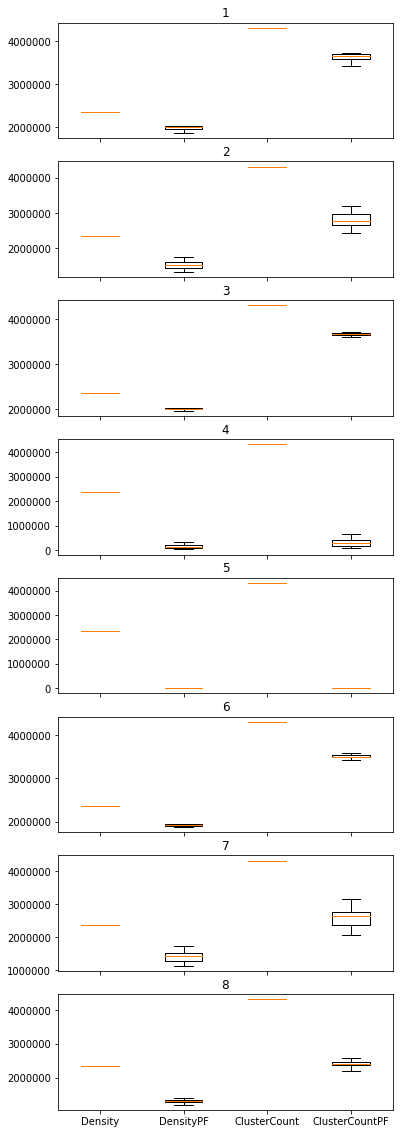

In [13]:
fig,ax=plt.subplots(8,1,figsize=(6,20),sharex=True)
for lane in range(1,9):
  l_data=Tile.groupby('Lane').get_group(str(lane))
  ax[lane-1].\
  boxplot(\
     [l_data['Density'].dropna().astype(float),
      l_data['DensityPF'].dropna().astype(float),
      l_data['ClusterCount'].dropna().astype(float),
      l_data['ClusterCountPF'].dropna().astype(float),
     ],
     labels=['Density',
             'DensityPF',
             'ClusterCount',
             'ClusterCountPF'])
  ax[lane-1].set_title(lane)

## QScore Distribution

In [21]:
QByLane=pd.DataFrame(data.get('QByLane'))

In [24]:
t_col=['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5', 'Bin_6', 'Bin_7']

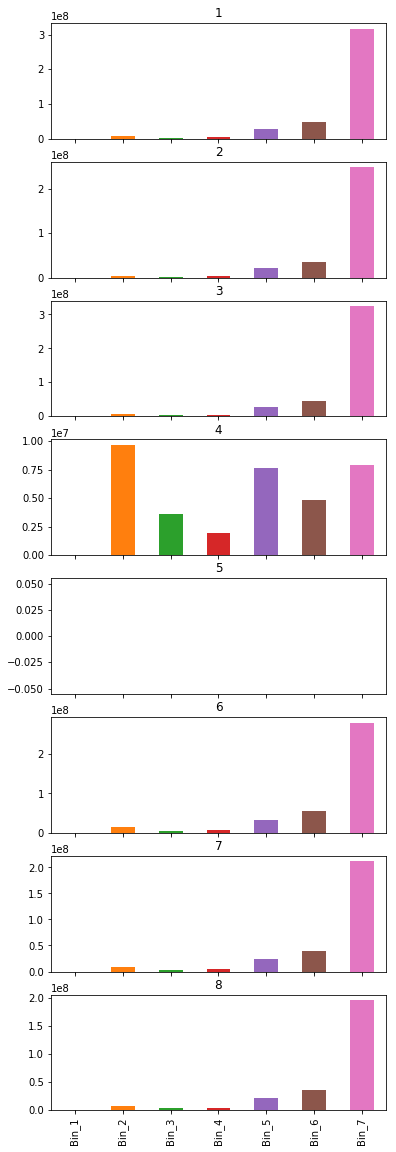

In [27]:
fig,ax=plt.subplots(8,1,figsize=(6,20),sharex=True)
for lane in range(1,9):
  QByLane.\
  groupby(['Lane']).\
  get_group(str(lane)).\
  fillna(0).\
  applymap(lambda x: int(x))[t_col].\
  mean().T.\
  plot(kind='bar',ax=ax[lane-1])
  ax[lane-1].set_title(lane);

## QScore Heatmap

In [28]:
Q2030=pd.DataFrame(data.get('Q2030'))

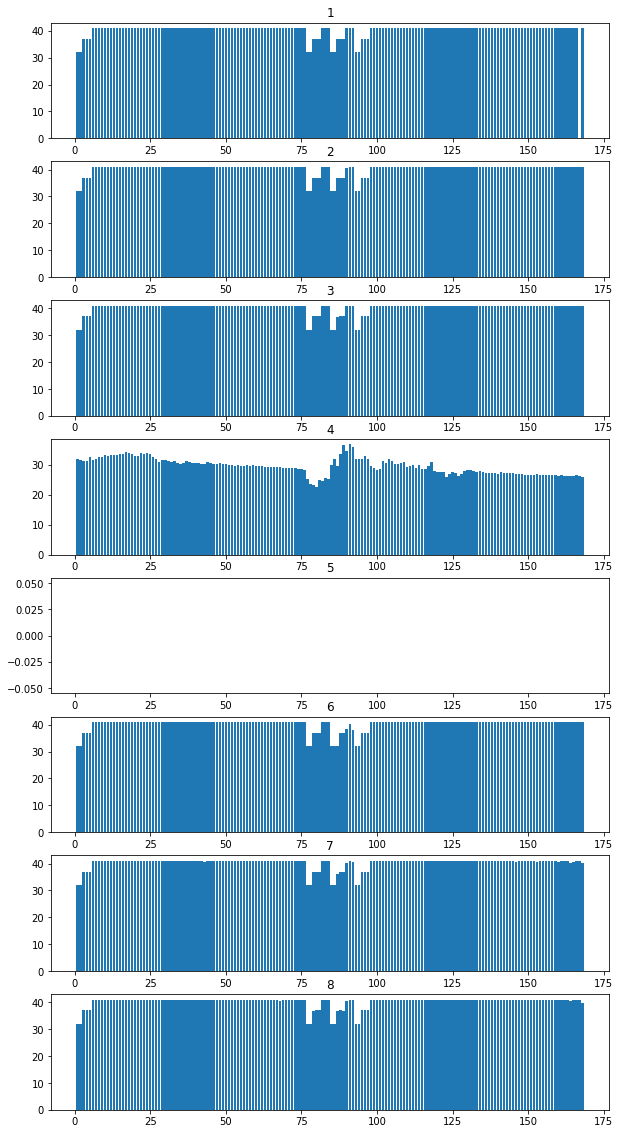

In [29]:
fig,ax=plt.subplots(8,1,figsize=(10,20))
for lane in range(1,9):
    tc_data=list()
    l_data=Q2030.\
           groupby('Lane').\
           get_group(str(lane)).\
           fillna(0).\
           applymap(lambda x: int(x)).\
           sort_values('Cycle')
    for cycle, c_data in l_data.groupby('Cycle'):
        q_score=c_data['MedianQScore'].mean()
        if int(q_score)>50:
            q_score=0
        tc_data.append({'Cycle':cycle,
                    'Q-score':q_score})
    tc_data=pd.DataFrame(tc_data)
    ax[int(lane)-1].bar(tc_data['Cycle'],tc_data['Q-score'])
    ax[int(lane)-1].set_title(lane)